In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns

from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

# If you're using 'category_encoders' for encoding, import it once
import category_encoders as ce

import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

# Introduction

Before we start this project, I would like to introduce the topics 'What Is Default Risk?' and 'Why Do We Predict Default Risk?'

## What Is Default Risk?

> Default risk is the risk a lender takes that a borrower will not make the required payments on a debt obligation, such as a loan, a bond, or a credit card. Lenders and investors are exposed to default risk in virtually all forms of credit offerings. A higher level of default risk typically requires the borrower to pay a higher interest rate. 

[REFERENCE: Default Risk: Definition, Types, and Ways to Measure](https://www.investopedia.com/terms/d/defaultrisk.asp)

## Why Do We Predict Default Risk?

> Predicting default helps banks assess the creditworthiness of potential borrowers and manage loan risk. 

[REFERENCE: Predicting Default](https://www.studysmarter.co.uk/explanations/business-studies/corporate-finance/predicting-default/)

## Understanding the requirement

[REFERENCE: Loan Approval Prediction Playground Series - Season 4, Episode 10](https://www.kaggle.com/competitions/playground-series-s4e10/overview)

### Goal

> The goal for this competition is to predict whether an applicant is approved for a loan.

### Evaluation

> Submissions are evaluated using area under the ROC curve using the predicted probabilities and the ground truth targets.

#### ROC curve

> The ROC curve stands for the Receiver Operating Characteristic curve. It is a graphical representation of the performance of a binary classifier at different classification thresholds. The curve plots the possible True Positive rates (TPR) against the False Positive rates (FPR).

[REFERENCE: How to explain the ROC curve and ROC AUC score?](https://www.evidentlyai.com/classification-metrics/explain-roc-curve).




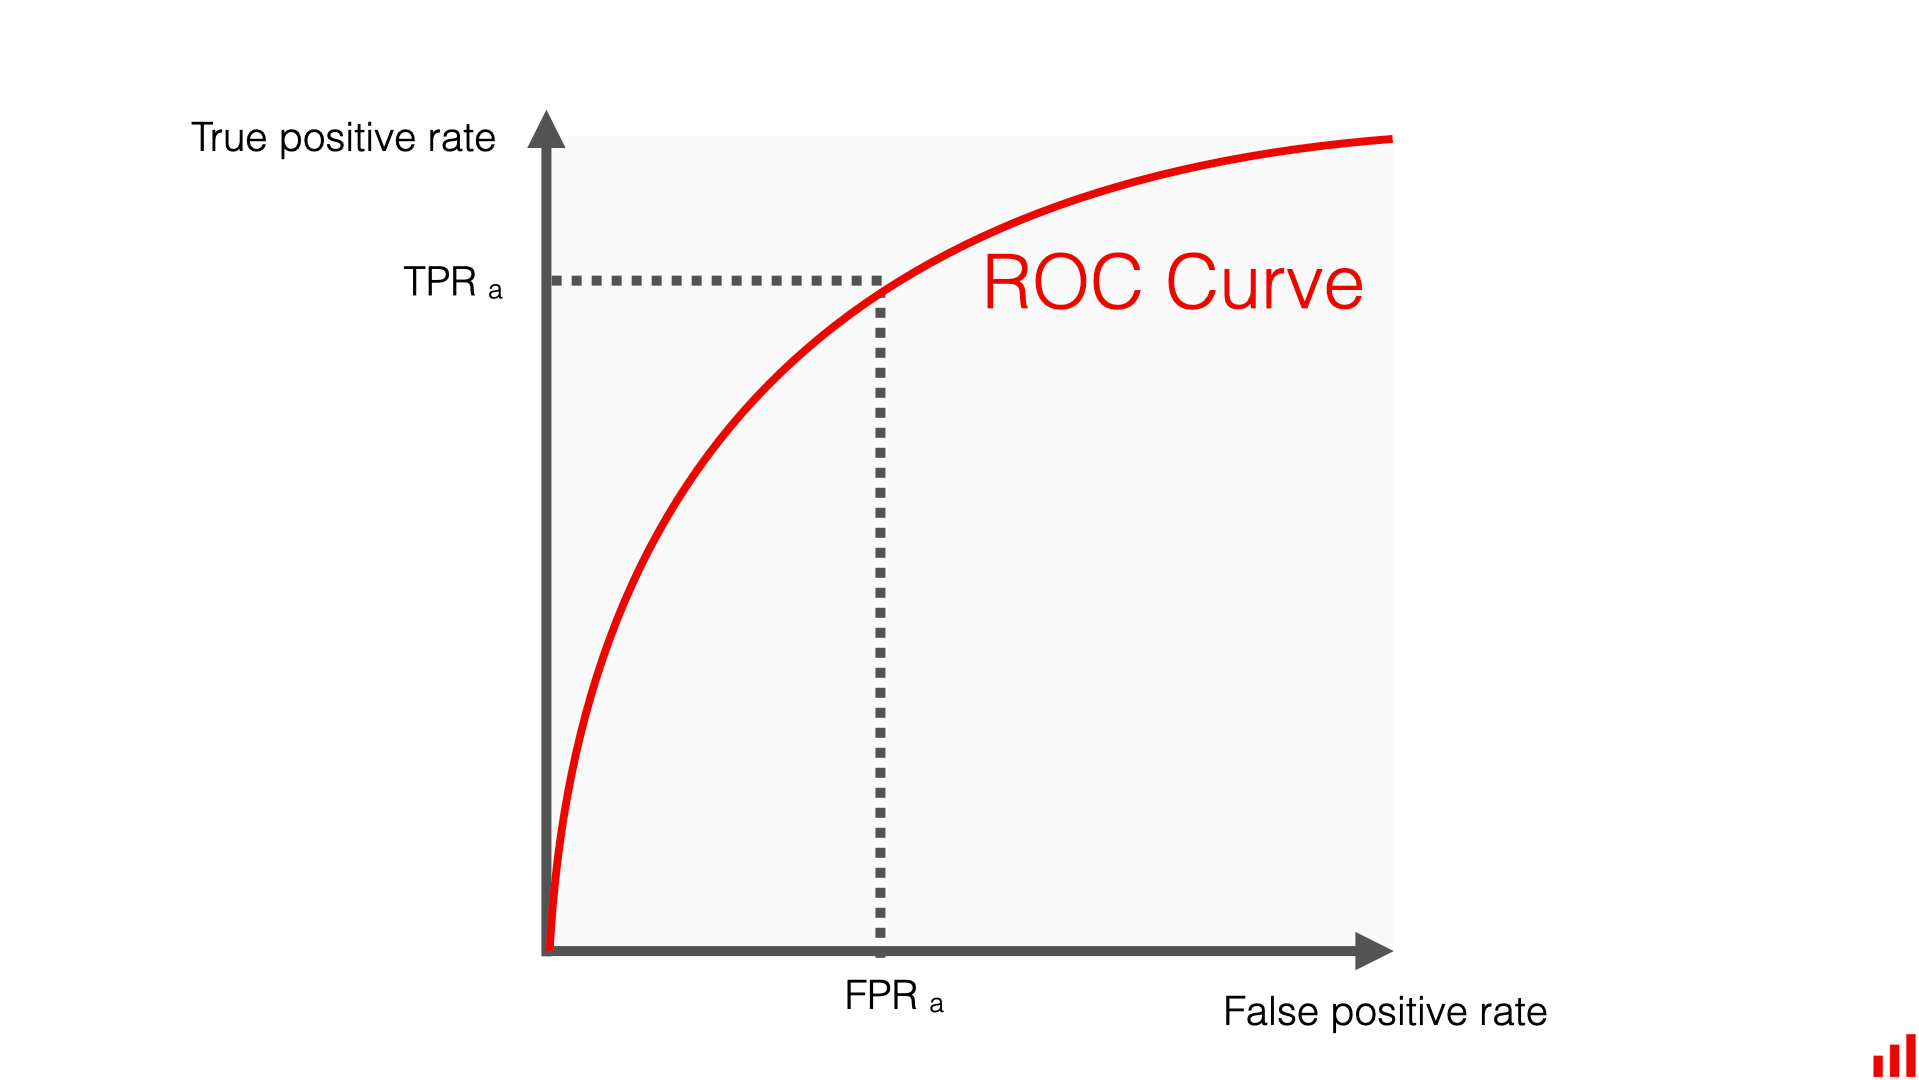

Thanks to the images from [evidentlyai](https://www.evidentlyai.com/classification-metrics/explain-roc-curve).

#### ROC AUC score

> ROC AUC stands for Receiver Operating Characteristic Area Under the Curve. 
ROC AUC score is a single number that summarizes the classifier's performance across all possible classification thresholds. To get the score, you must measure the area under the ROC curve.

[REFERENCE: How to explain the ROC curve and ROC AUC score?](https://www.evidentlyai.com/classification-metrics/explain-roc-curve).

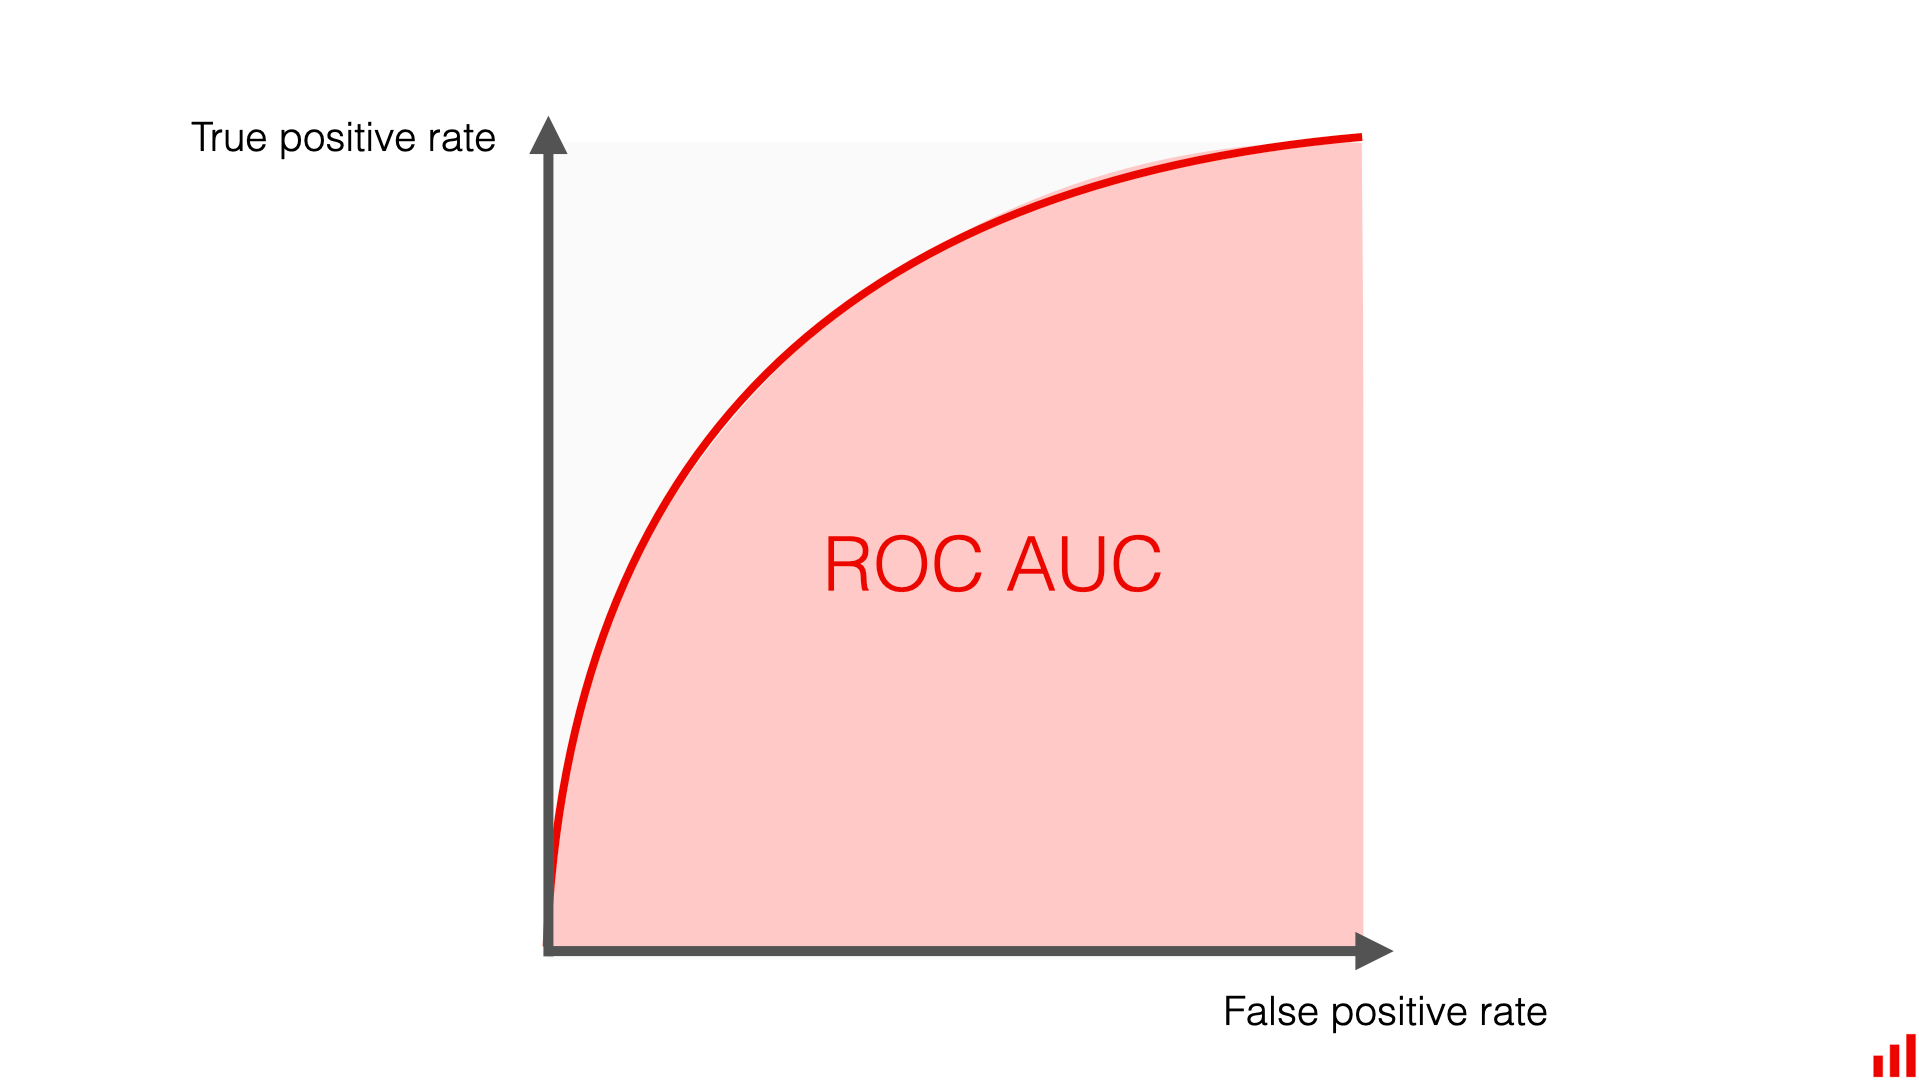

Thanks to the images from [evidentlyai](https://www.evidentlyai.com/classification-metrics/explain-roc-curve).

### Submission File

> For each id row in the test set, you must predict target loan_status. The file should contain a header and have the following format:

*id,loan_status*

# Data Observation

In [2]:
sample_submission = pd.read_csv("/kaggle/input/playground-series-s4e10/sample_submission.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")
train = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")

In [3]:
len(train.columns)

13

In [4]:
len(test.columns)

12

In [5]:
common_columns = train.columns.intersection(test.columns)
common_columns

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length'],
      dtype='object')

In [6]:
diff_columns = train.columns.difference(test.columns)
diff_columns

Index(['loan_status'], dtype='object')

We have observed that **loan_status** is the only column present in the train dataset but not in the test dataset. However, all other columns are the same in both the train and test datasets.

## Missing values

In [7]:
train.isnull().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [8]:
test.isnull().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [9]:
train.isna().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [10]:
test.isna().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [11]:
train.duplicated().sum()

0

In [12]:
test.duplicated().sum()

0

In [13]:
train.head(5)

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [15]:
train.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


# Data visulization

In [16]:
numerical_columns = list(train.select_dtypes(include=['number']).columns.drop(['id','loan_status'], errors='ignore'))
categorical_columns = list(train.select_dtypes(include = ['object', 'category']).columns)


In [17]:
list(categorical_columns)

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

We have the following categorical columns: person_home_ownership, loan_intent, loan_grade, and cb_person_default_on_file.

In [18]:
numerical_columns

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length']

We have the following numerical columns: person_age, person_income, person_emp_length, loan_amnt, loan_int_rate, loan_percent_income, and cb_person_cred_hist_length.

## Categorical columns

In this section, I will introduce the categorical columns and their corresponding bar charts.

### person_home_ownership 
person_home_ownership is a categorical column that shows whether a person rents, owns, has a mortgage, or has another type of property ownership.

In [19]:
train["person_home_ownership"].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object)

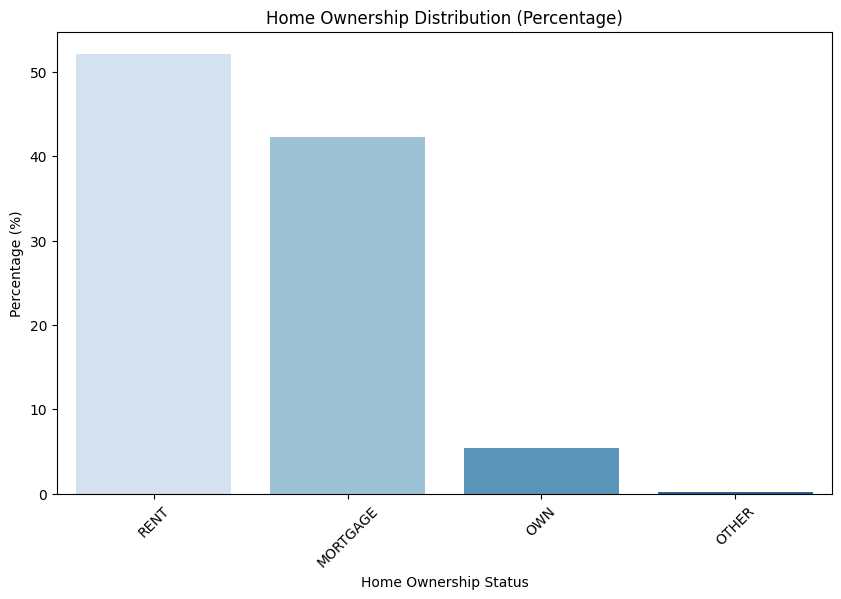

In [20]:
# Count unique values and calculate percentages
home_ownership_counts = train["person_home_ownership"].value_counts()
home_ownership_percentages = (home_ownership_counts / home_ownership_counts.sum()) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x=home_ownership_percentages.index, y=home_ownership_percentages.values, palette='Blues')
plt.title('Home Ownership Distribution (Percentage)')
plt.xlabel('Home Ownership Status')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.show()


We can see that the majority of individuals have a home ownership status of **RENT**, accounting for more than half of the total. This is followed by MORTGAGE and OWN, with **OTHER** making up about 5%.

### loan_intent

loan_intent shows the purpose of the loan, which can be for education, medical, personal, venture, debt consolidation, or home improvement.

In [21]:
train["loan_intent"].unique()

array(['EDUCATION', 'MEDICAL', 'PERSONAL', 'VENTURE', 'DEBTCONSOLIDATION',
       'HOMEIMPROVEMENT'], dtype=object)

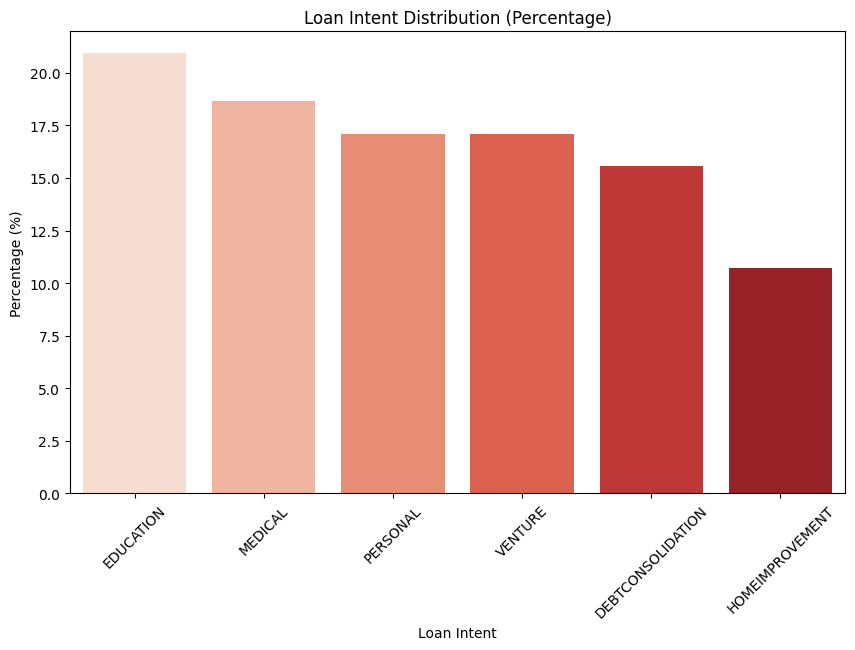

In [22]:
# Count unique values and calculate percentages
loan_intent_counts = train["loan_intent"].value_counts()
loan_intent_percentages = (loan_intent_counts / loan_intent_counts.sum()) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x=loan_intent_percentages.index, y=loan_intent_percentages.values, palette='Reds')
plt.title('Loan Intent Distribution (Percentage)')
plt.xlabel('Loan Intent')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.show()


We can see that the majority of individuals have a loan intent of **EDUCATION**. This is followed by MEDICAL, while PERSONAL and VENTURE have quite similar amounts.

### loan_grade

Loan grading is a classification system that involves assigning a quality score to a loan based on a borrower's credit history, quality of the collateral, and the likelihood of repayment of the principal and interest.
https://www.investopedia.com/terms/l/loan-grading.asp

loan_grade has 7 grades: A, B, C, D, E, F, and G, with A being the best grade.

In [23]:
train["loan_grade"].unique()

array(['B', 'C', 'A', 'D', 'E', 'F', 'G'], dtype=object)

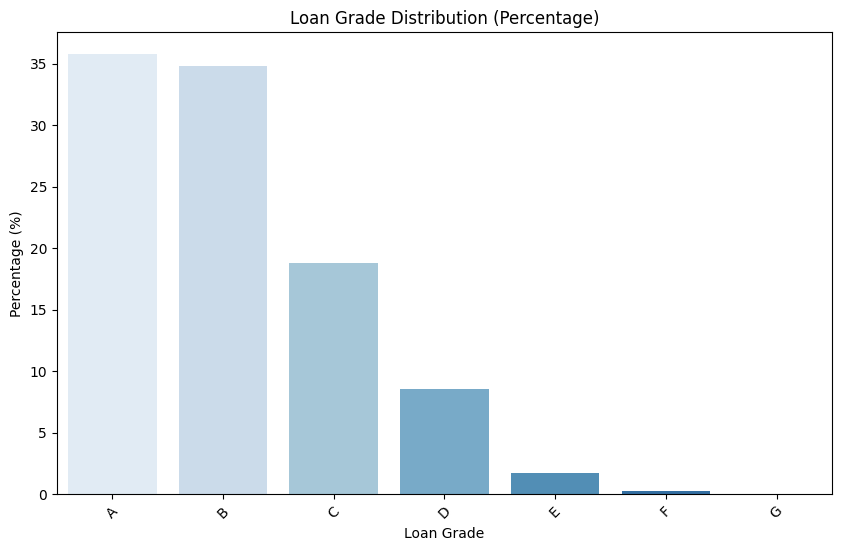

In [24]:
# Count unique values and calculate percentages
loan_grade_counts = train["loan_grade"].value_counts()
loan_grade_percentages = (loan_grade_counts / loan_grade_counts.sum()) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x=loan_grade_percentages.index, y=loan_grade_percentages.values, palette='Blues')
plt.title('Loan Grade Distribution (Percentage)')
plt.xlabel('Loan Grade')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.show()


We can see that grades **A** and **B** have similar proportions, while grade **C** has about half of their counts. This is followed by grades **D**, **E**, **F**, and **G**.

### cb_person_default_on_file

cb_person_default_on_file indicates whether a person has defaulted on a debt. The value is 'Y' if they have defaulted, and 'N' if they have not.

In [25]:
train["cb_person_default_on_file"].unique()

array(['N', 'Y'], dtype=object)

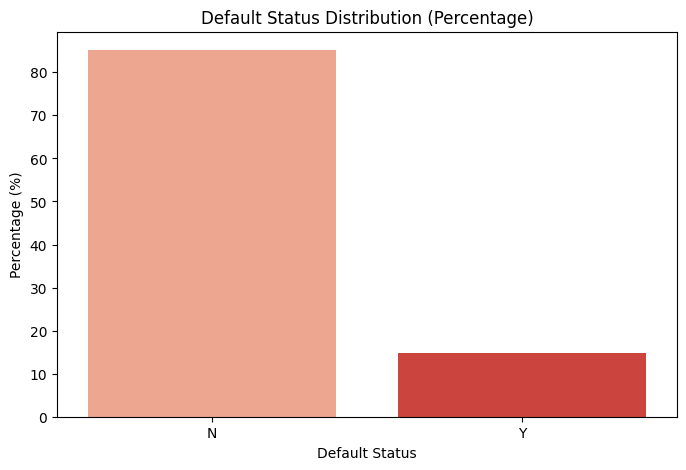

In [26]:
# Count unique values and calculate percentages
default_status_counts = train["cb_person_default_on_file"].value_counts()
default_status_percentages = (default_status_counts / default_status_counts.sum()) * 100

plt.figure(figsize=(8, 5))
sns.barplot(x=default_status_percentages.index, y=default_status_percentages.values, palette='Reds')
plt.title('Default Status Distribution (Percentage)')
plt.xlabel('Default Status')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)  # No rotation for better visibility
plt.show()


<Figure size 1000x600 with 0 Axes>

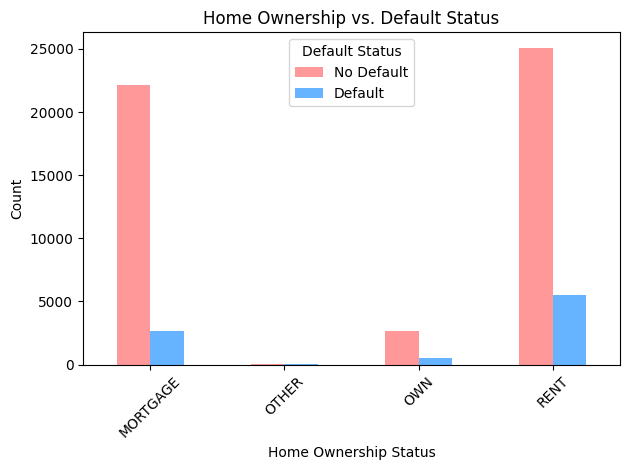

In [27]:
# Count occurrences of default status for each home ownership category
home_default_counts = train.groupby(['person_home_ownership', 'cb_person_default_on_file']).size().unstack()

# Plotting
plt.figure(figsize=(10, 6))
home_default_counts.plot(kind='bar', stacked=False, color=['#ff9999', '#66b3ff'])
plt.title('Home Ownership vs. Default Status')
plt.xlabel('Home Ownership Status')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.legend(title='Default Status', labels=['No Default', 'Default'])
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()

We can see that individuals who rent are more likely to default, followed by those with mortgages, homeowners, and others. However, individuals who do not default are mostly found among renters, mortgagors, homeowners, and others.


<Figure size 1000x600 with 0 Axes>

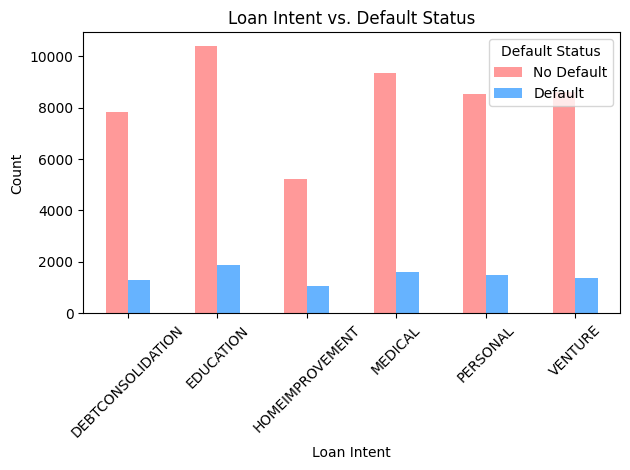

In [28]:
# Count occurrences of default status for each loan intent category
loan_default_counts = train.groupby(['loan_intent', 'cb_person_default_on_file']).size().unstack()

# Plotting
plt.figure(figsize=(10, 6))
loan_default_counts.plot(kind='bar', stacked=False, color=['#ff9999', '#66b3ff'])
plt.title('Loan Intent vs. Default Status')
plt.xlabel('Loan Intent')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.legend(title='Default Status', labels=['No Default', 'Default'])
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()


We can see that when the loan intent is for EDUCATION, the chance of default is highest, while it is lowest for HOME IMPROVEMENT.

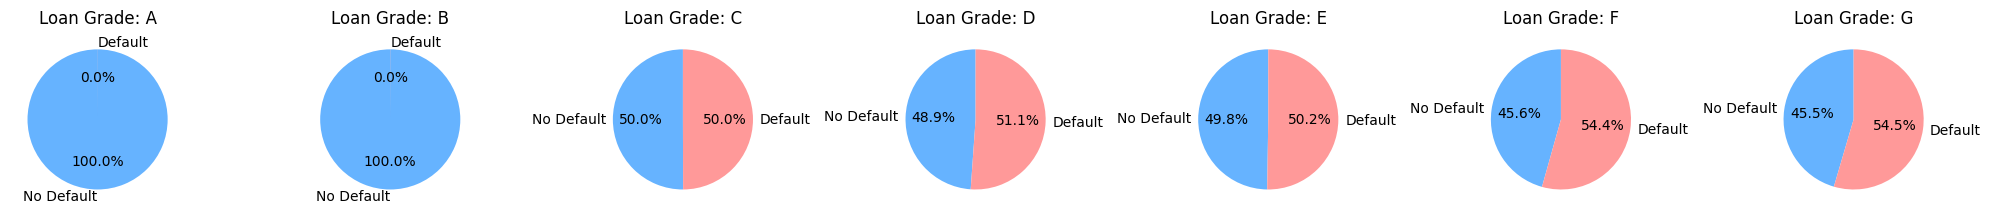

In [29]:
# Count occurrences of default status for each loan grade category
grade_default_counts = train.groupby(['loan_grade', 'cb_person_default_on_file']).size().unstack().fillna(0)

# Plotting pie charts for each loan grade
fig, axes = plt.subplots(1, len(grade_default_counts), figsize=(20, 6))

for ax, (grade, counts) in zip(axes, grade_default_counts.iterrows()):
    ax.pie(counts, labels=['No Default', 'Default'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
    ax.set_title(f'Loan Grade: {grade}')

plt.tight_layout()  # Adjust layout to make room for titles
plt.show()


We can see that grades A and B have 0 defaults, meaning 100% of individuals did not default. Grade C has a similar proportion, while grades D, E, F, and G have a slightly higher rate of defaults.

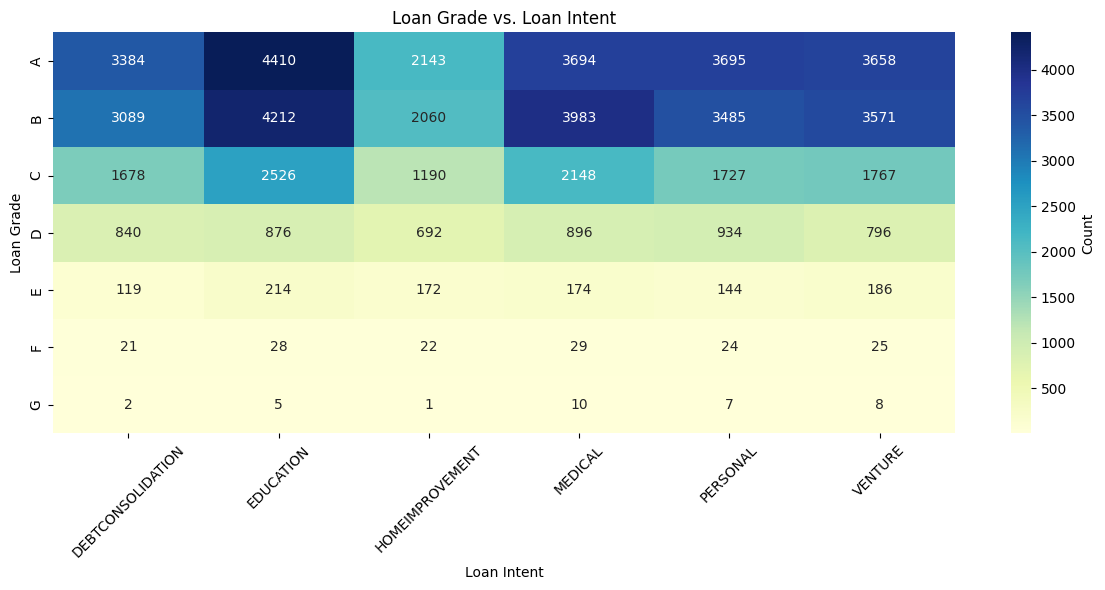

In [30]:
# Count occurrences of loan intent for each loan grade category
intent_grade_counts = train.groupby(['loan_grade', 'loan_intent']).size().unstack()

# Plotting heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(intent_grade_counts, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Count'})
plt.title('Loan Grade vs. Loan Intent')
plt.xlabel('Loan Intent')
plt.ylabel('Loan Grade')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()


<Figure size 1200x600 with 0 Axes>

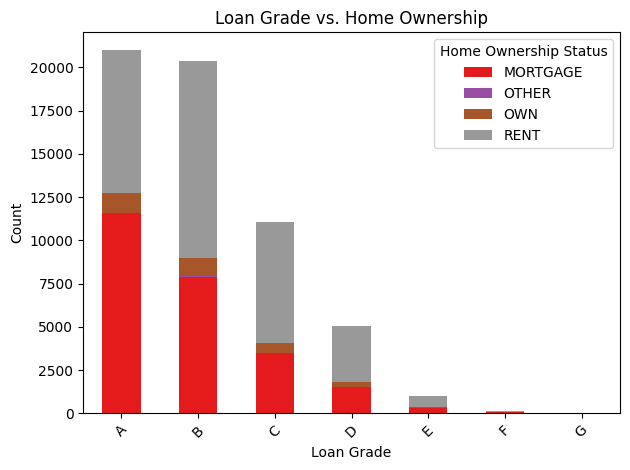

In [31]:
# Count occurrences of home ownership for each loan grade category
ownership_grade_counts = train.groupby(['loan_grade', 'person_home_ownership']).size().unstack()

# Plotting stacked bar chart
plt.figure(figsize=(12, 6))
ownership_grade_counts.plot(kind='bar', stacked=True, cmap='Set1')
plt.title('Loan Grade vs. Home Ownership')
plt.xlabel('Loan Grade')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.legend(title='Home Ownership Status')
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()


## Numerical columns

* **person_age**: person_age shows the age of the borrower.
* **person_income**: person_income shows the income of the borrower.
* **person_emp_length**: person_emp_length shows the length of the borrower's employment.
* **loan_amnt**: loan_amnt shows the amount of the loan.
* **loan_percent_income**: loan_percent_income shows the ratio of the loan to income, expressed as a percentage.
* **cb_person_cred_hist_length**: cb_person_cred_hist_length shows the number of years of credit history since the borrower’s first loan.

[REFERENCE: Credit Risk Assessment](https://rpubs.com/alin123/Credit-Risk-Assessment)

#### Histograms

In this section, I would like to introduce the numerical columns and theirs distribution plots which  the shape of the graph when all possible values are plotted on a frequency graph

[REFERENCE: Distribution of data](https://www.learninghub.ac.nz/distribution-of-data/#:~:text=The%20distribution%20of%20a%20data,showing%20how%20often%20they%20occur)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

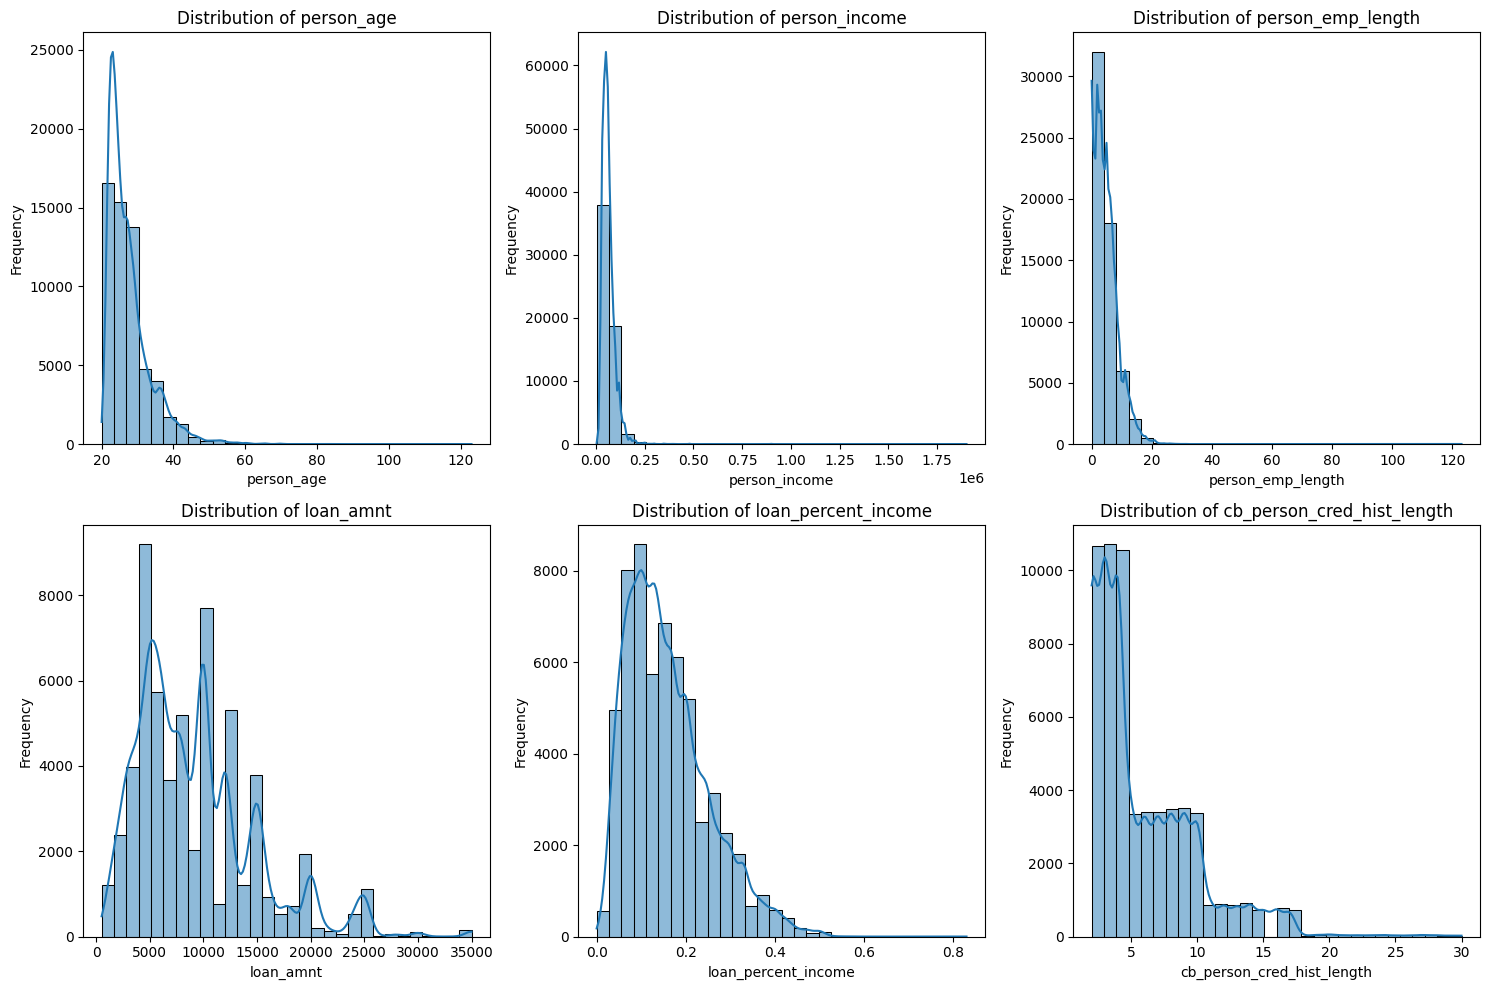

In [32]:
# List of columns to plot
columns_to_plot = [
    "person_age",
    "person_income",
    "person_emp_length",
    "loan_amnt",
    "loan_percent_income",
    "cb_person_cred_hist_length"
]

# Set the number of subplots
num_columns = len(columns_to_plot)
plt.figure(figsize=(15, 10))

# Create a histogram for each column
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 3, i)  # Create a 2x3 grid for subplots
    sns.histplot(train[column], bins=30, kde=True)  # Using Seaborn's histplot for better aesthetics
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()  # Adjusts subplots to fit into the figure area.
plt.show()


All the features exhibit a right-skewed distribution.

#### Boxplots

> A box and whisker plot or diagram (otherwise known as a boxplot), is a graph summarising a set of data. The shape of the boxplot shows how the data is distributed and it also shows any outliers. 

[REFERENCE: Box and Whisker Plots](https://www.ncl.ac.uk/webtemplate/ask-assets/external/maths-resources/statistics/data-presentation/box-and-whisker-plots.html)

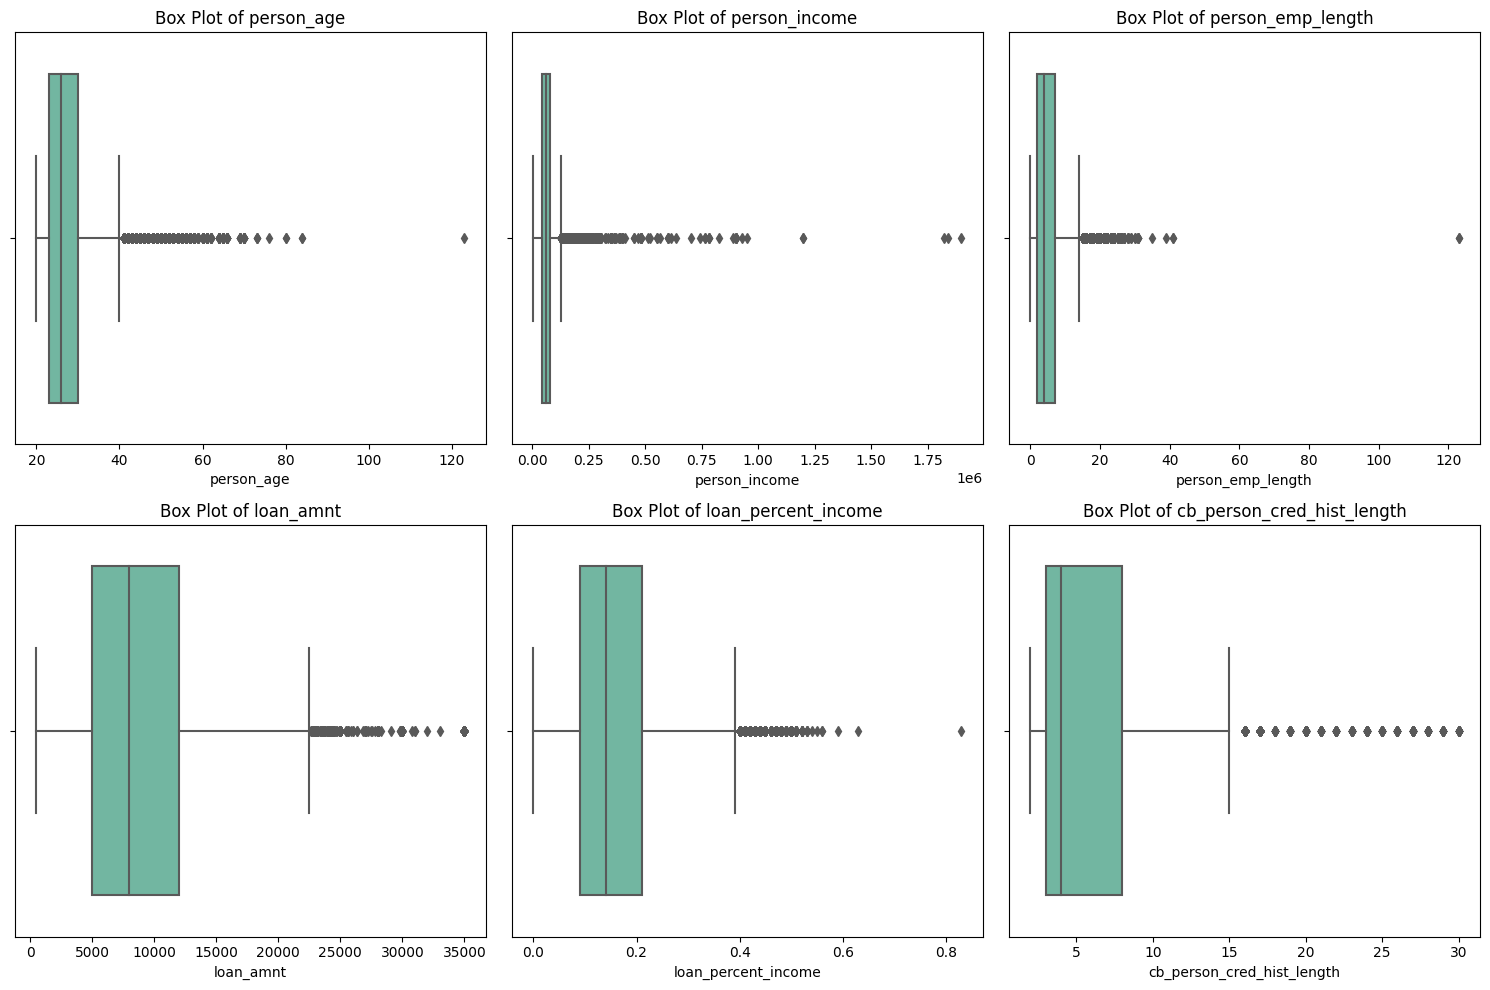

In [33]:
# Set the number of subplots
num_columns = len(columns_to_plot)
plt.figure(figsize=(15, 10))

# Create a box plot for each column
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 3, i)  # Create a 2x3 grid for subplots
    sns.boxplot(x=train[column], palette='Set2')  # Using Seaborn's boxplot
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)

plt.tight_layout()  # Adjusts subplots to fit into the figure area.
plt.show()


All the features exhibit a right-skewed distribution and contain a significant number of outliers across all features.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

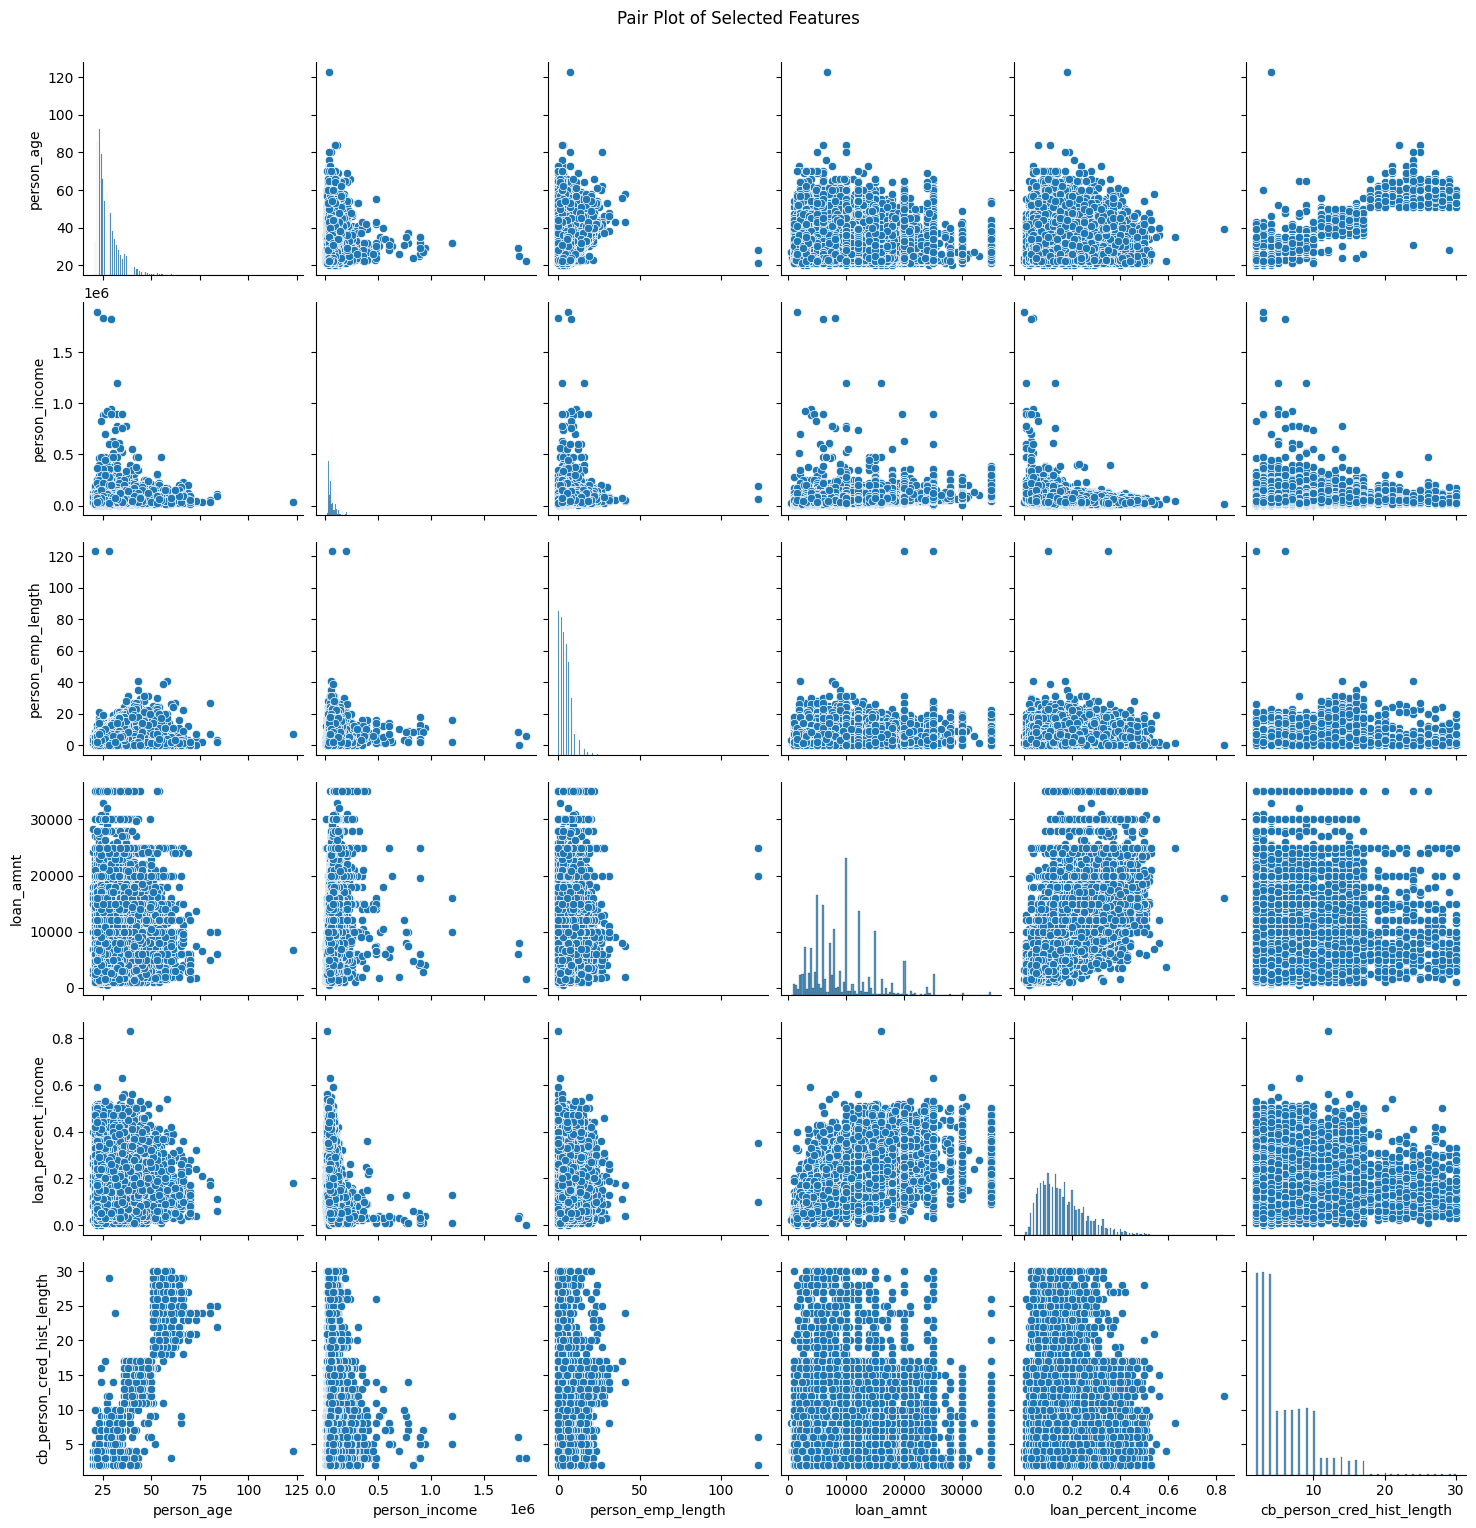

In [34]:
# Create a pair plot
sns.pairplot(train[columns_to_plot])
plt.suptitle('Pair Plot of Selected Features', y=1.02)  # Title for the plot
plt.show()

The pair plots reveal a significant number of outliers across all features. 

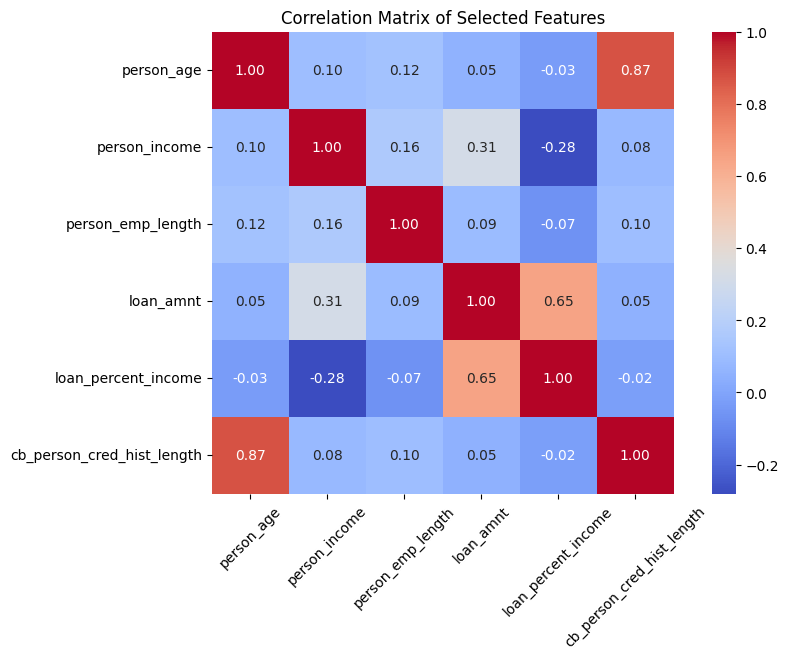

In [35]:
# Calculate the correlation matrix
correlation_matrix = train[columns_to_plot].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)

# Add titles and labels
plt.title('Correlation Matrix of Selected Features')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.yticks(rotation=0)   # Rotate y labels for better visibility
plt.show()


We can see that **person_age** has a high correlation with **cb_person_cred_hist_length** (0.82). 
This suggests that as a person's age increases, the length of their credit history tends to increase as well. This relationship may indicate that older individuals generally have more extensive credit histories, potentially due to having more years of financial experience and a longer time to establish credit.

## Categorical and Numerical columns

> A **boxplot**, also known as a box plot, box plots, or box-and-whisker plot, is a standardized way of displaying the distribution of a data set based on its five-number summary of data points: the “minimum,” first quartile [Q1], median, third quartile [Q3] and “maximum.” Here’s an example.

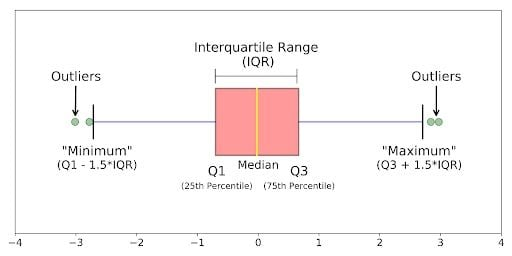

[REFERENCE: What Is a Boxplot? Here’s What You Should Know.](https://builtin.com/data-science/boxplot)

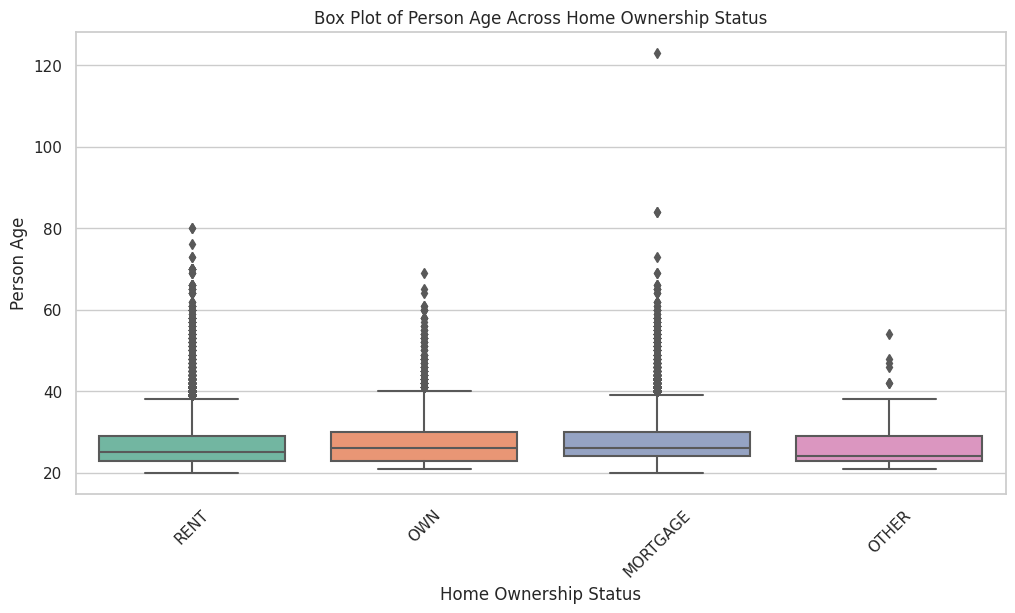

In [36]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Create a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='person_home_ownership', y='person_age', data=train, palette='Set2')

# Title and labels
plt.title('Box Plot of Person Age Across Home Ownership Status')
plt.xlabel('Home Ownership Status')
plt.ylabel('Person Age')

# Show the plot
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.show()


From the box plot above, I observed that there is a person over the age of 120 who has a mortgage, which seems unusual.

The home ownership status is OTHER, and the range from Q1 to the median is small. This indicates that the lower half of the data is tightly concentrated.

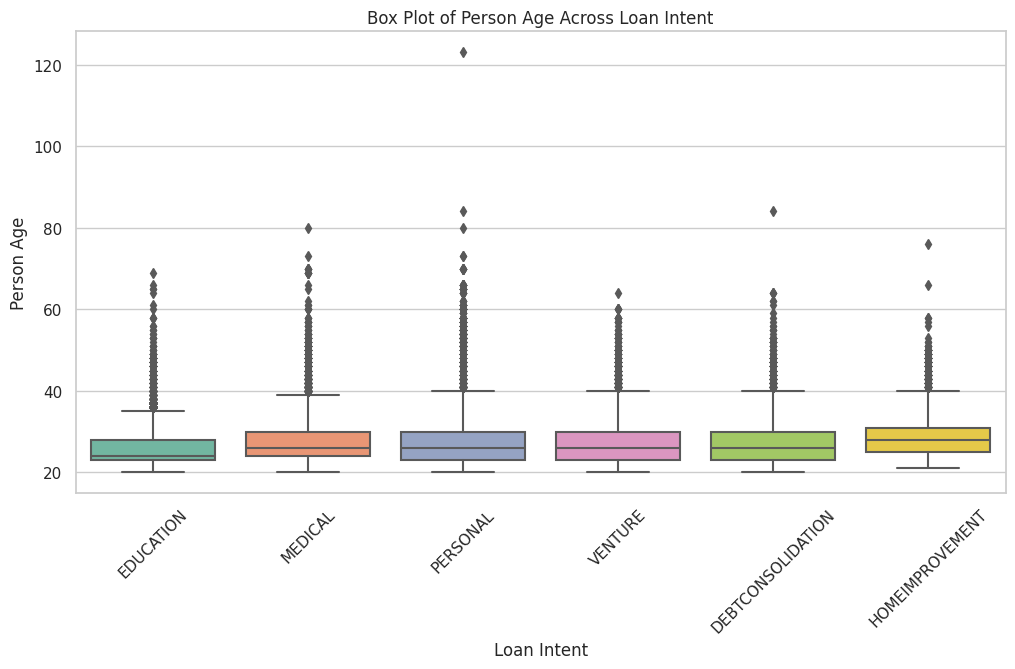

In [37]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Create a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='loan_intent', y='person_age', data=train, palette='Set2')

# Title and labels
plt.title('Box Plot of Person Age Across Loan Intent')
plt.xlabel('Loan Intent')
plt.ylabel('Person Age')

# Show the plot
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.show()


Most loan intent categories, such as PERSONAL, VENTURE, and DEBTCONSOLIDATION, exhibit relatively consistent age distributions, as indicated by similar median ages. It shows that the spread of ages within these categories is quite similar. This consistency in the age range could imply that these types of loans attract individuals in a similar age group.

Outliers are present in all loan intent categories

For EDUCATION, the range from the minimum age to the median is the smallest compared to the other loan intent categories. 

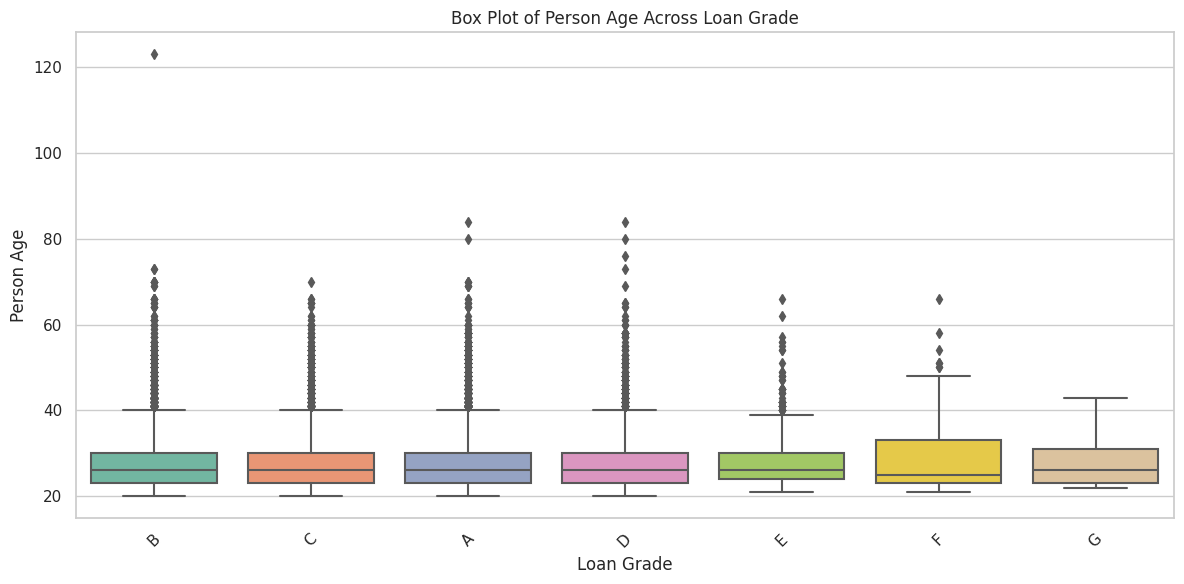

In [38]:
# Creating a box plot for person_age across loan_grade
plt.figure(figsize=(12, 6))
sns.boxplot(data=train, x='loan_grade', y='person_age', palette='Set2')
plt.title('Box Plot of Person Age Across Loan Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Person Age')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.tight_layout()
plt.show()

Grade F has the lowest median person age compared to other loan grades.

Grades A, B, C, and D have similar amounts of outliers. However, Grade G has no outliers.

Grade F's upper whisker is significantly larger, meaning that the top 25% of the age distribution has a wider range compared to other grades. This suggests that the older individuals in Grade F span a broader age range, possibly indicating that a more diverse group of older applicants exists in this category.

# Data preprocessing

> Data preprocessing is the process of evaluating, filtering, manipulating, and encoding data so that a machine learning algorithm can understand it and use the resulting output. The major goal of data preprocessing is to eliminate data issues such as missing values, improve data quality, and make the data useful for machine learning purposes.

[REFERENCES: Data Preprocessing in Machine Learning: Steps & Best Practices](https://lakefs.io/blog/data-preprocessing-in-machine-learning/)

In [39]:
def feature_engineering(df):
    # Person Age Buckets
    # df['age_bucket'] = pd.cut(df['person_age'], bins=[18, 25, 35, 50, 60, 100], labels=['18-25', '26-35', '36-50', '51-60', '60+'])

    # Log Transformation on Income and Loan Amount
    df['log_person_income'] = np.log1p(df['person_income'])
    df['log_loan_amnt'] = np.log1p(df['loan_amnt'])

    # Income to Loan Ratio
    df['income_to_loan_ratio'] = df['person_income'] / (df['loan_amnt'] + 1)

    # Employment Length Buckets
    df['emp_length_bucket'] = pd.cut(df['person_emp_length'], bins=[0, 1, 5, 10, 20], labels=['0-1', '2-5', '6-10', '10+'])

    # Interaction Feature: Credit History to Age Ratio
    df['cred_hist_to_age_ratio'] = df['cb_person_cred_hist_length'] / (df['person_age'] + 1)

    # Binary Feature for High Loan Percent Income
    df['high_loan_percent_income'] = (df['loan_percent_income'] > 0.7).astype(int)

    # Default History Binary Encoding
    df['cb_person_default_on_file'] = df['cb_person_default_on_file'].map({'Yes': 1, 'No': 0})

    return df


In [40]:
train = feature_engineering(train)
test = feature_engineering(test)

In [41]:
numerical_columns

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length']

In [42]:
categorical_columns

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder

def data_preprocessing(train, test, numerical_columns, categorical_columns):
    
    # Apply Robust Scaler to numerical columns
    scaler = RobustScaler()
    train[numerical_columns] = scaler.fit_transform(train[numerical_columns])
    test[numerical_columns] = scaler.transform(test[numerical_columns])
    
    # Label Encoding on 'loan_grade' 
    label_encoder = LabelEncoder()
    train['loan_grade'] = label_encoder.fit_transform(train['loan_grade'])
    test['loan_grade'] = label_encoder.transform(test['loan_grade'])
    
    # One-Hot Encoding on categorical columns
    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')  
    # Drop the first level to avoid multicollinearity
    one_hot_encoded_train = encoder.fit_transform(train[categorical_columns])
    one_hot_encoded_test = encoder.transform(test[categorical_columns])
    
    # Convert one-hot encoded arrays back to DataFrames
    one_hot_encoded_train_df = pd.DataFrame(one_hot_encoded_train, columns=encoder.get_feature_names_out(categorical_columns))
    one_hot_encoded_test_df = pd.DataFrame(one_hot_encoded_test, columns=encoder.get_feature_names_out(categorical_columns))
    
    # Reset index for concatenation compatibility
    one_hot_encoded_train_df.index = train.index
    one_hot_encoded_test_df.index = test.index
    
    # Concatenate the one-hot encoded columns with the original train/test datasets
    train = pd.concat([train.drop(categorical_columns, axis=1), one_hot_encoded_train_df], axis=1)
    test = pd.concat([test.drop(categorical_columns, axis=1), one_hot_encoded_test_df], axis=1)

    return train, test  # Return the processed train and test datasets


Before applying the data_preprocessing function, we need to separate the target (loan_status) from the dataset to ensure that the target (loan_status) is not affected by the preprocessing steps.

In [44]:
X_train = train.drop(columns=['loan_status'])
y_train = train['loan_status']

X_test = test

X_train_processed, X_test_processed = data_preprocessing(X_train, X_test, numerical_columns, categorical_columns)

In [45]:
X_test_processed

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,log_person_income,log_loan_amnt,...,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_1,loan_grade_2,loan_grade_3,loan_grade_4,loan_grade_5,loan_grade_6
0,58645,-0.428571,0.327381,-0.2,2.428571,0.980431,1.833333,-0.4,11.141876,10.126671,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,58646,0.000000,1.130952,0.4,0.285714,0.377691,-0.333333,0.0,11.472114,9.210440,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,58647,0.000000,-0.833333,0.2,-0.571429,1.260274,-0.083333,-0.4,10.308986,8.294300,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,58648,1.000000,-0.238095,0.0,-0.142857,-0.362035,0.000000,0.6,10.819798,8.853808,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,58649,0.000000,1.309524,0.8,1.000000,1.090020,0.083333,0.0,11.532738,9.615872,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39093,97738,-0.571429,-0.797619,-0.4,-0.714286,-0.074364,-0.333333,0.0,10.348205,8.006701,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
39094,97739,-0.571429,-0.297619,0.4,-0.142857,-0.923679,0.083333,-0.2,10.778977,8.853808,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39095,97740,3.571429,0.059524,-0.8,1.000000,-0.634051,0.916667,4.2,11.002117,9.615872,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39096,97741,-0.571429,-0.654762,0.0,0.857143,0.953033,2.083333,0.0,10.491302,9.546884,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [46]:
X_test_processed

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,log_person_income,log_loan_amnt,...,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_1,loan_grade_2,loan_grade_3,loan_grade_4,loan_grade_5,loan_grade_6
0,58645,-0.428571,0.327381,-0.2,2.428571,0.980431,1.833333,-0.4,11.141876,10.126671,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,58646,0.000000,1.130952,0.4,0.285714,0.377691,-0.333333,0.0,11.472114,9.210440,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,58647,0.000000,-0.833333,0.2,-0.571429,1.260274,-0.083333,-0.4,10.308986,8.294300,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,58648,1.000000,-0.238095,0.0,-0.142857,-0.362035,0.000000,0.6,10.819798,8.853808,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,58649,0.000000,1.309524,0.8,1.000000,1.090020,0.083333,0.0,11.532738,9.615872,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39093,97738,-0.571429,-0.797619,-0.4,-0.714286,-0.074364,-0.333333,0.0,10.348205,8.006701,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
39094,97739,-0.571429,-0.297619,0.4,-0.142857,-0.923679,0.083333,-0.2,10.778977,8.853808,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39095,97740,3.571429,0.059524,-0.8,1.000000,-0.634051,0.916667,4.2,11.002117,9.615872,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39096,97741,-0.571429,-0.654762,0.0,0.857143,0.953033,2.083333,0.0,10.491302,9.546884,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Modeling

## Lightgbm

In [47]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

# Define the objective function for Optuna hyperparameter tuning
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': 1000,
        'max_depth': trial.suggest_int('max_depth', 6, 12),
        'num_leaves': trial.suggest_int('num_leaves', 31, 128),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),
        'random_state': 42,
        'verbosity': -1,
        'device': 'gpu'  # Use GPU for faster training if available
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = []

    for train_idx, val_idx in cv.split(X_train_processed, y_train):
        X_train_fold, X_val_fold = X_train_processed.iloc[train_idx], X_train_processed.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Create the LightGBM model using the scikit-learn API
        model = lgb.LGBMClassifier(**params)
        
        # Fit the model with early stopping using the callbacks parameter
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            eval_metric='auc',
            callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
        )

        val_pred = model.predict_proba(X_val_fold)[:, 1]
        score = roc_auc_score(y_val_fold, val_pred)
        scores.append(score)

    return np.mean(scores)

# Set up Optuna study for hyperparameter optimization
sqlite_db = "sqlite:///lightgbm.db"
study_name = "lightgbm"

try:
    # Load the existing Optuna study if it exists
    study = optuna.load_study(study_name=study_name, storage=sqlite_db)
    print("Loaded existing Optuna study.")
except KeyError:
    # Create a new Optuna study if it doesn't exist
    study = optuna.create_study(
        study_name=study_name,
        direction="maximize",
        storage=sqlite_db,
        sampler=optuna.samplers.TPESampler(seed=0),
        load_if_exists=True
    )
    print("Created a new Optuna study.")

# Optimize hyperparameters using Optuna
study.optimize(objective, n_trials=100)
print(f"Best ROC-AUC score: {study.best_value:.5f}")
print(f"Best hyperparameters: {study.best_params}")

# Use the best parameters from Optuna for model training
best_params = study.best_params
best_params.update({
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'random_state': 42,
    'verbosity': -1,
    'device': 'gpu'  # Use GPU for faster inference if available
})

# Cross-validation and model training using the best hyperparameters
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = []
test_preds = []

for i, (train_idx, val_idx) in enumerate(cv.split(X_train_processed, y_train)):
    X_train_fold, X_val_fold = X_train_processed.iloc[train_idx], X_train_processed.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Create the LightGBM model using the best parameters
    model = lgb.LGBMClassifier(**best_params)

    # Fit the model with early stopping using the callbacks parameter
    model.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
    )

    val_pred = model.predict_proba(X_val_fold)[:, 1]
    score = roc_auc_score(y_val_fold, val_pred)
    scores.append(score)

    # Generate test predictions for each fold
    test_pred = model.predict_proba(X_test_processed)[:, 1]
    test_preds.append(test_pred)
    print(f'Fold {i + 1} ROC-AUC score: {score:.5f}')

# Calculate the final test predictions by averaging over all folds
final_test_pred = np.mean(test_preds, axis=0)

print(f'Cross-validated ROC-AUC score: {np.mean(scores):.3f} ± {np.std(scores):.3f}')
print(f'Max ROC-AUC score: {np.max(scores):.3f}')
print(f'Min ROC-AUC score: {np.min(scores):.3f}')

[I 2024-10-28 08:50:26,541] A new study created in RDB with name: lightgbm


Created a new Optuna study.


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
[I 2024-10-28 08:50:56,943] Trial 0 finished with value: 0.9561668907934207 and parameters: {'learning_rate': 0.0646642271741456, 'max_depth': 11, 'num_leaves': 90, 'min_child_samples': 64, 'feature_fraction': 0.7694619197355619, 'bagging_fraction': 0.8583576452266624, 'lambda_l1': 2.1879360563134624, 'lam

Best ROC-AUC score: 0.95818
Best hyperparameters: {'learning_rate': 0.08591438289611936, 'max_depth': 11, 'num_leaves': 32, 'min_child_samples': 45, 'feature_fraction': 0.618667473705796, 'bagging_fraction': 0.7386861019403057, 'lambda_l1': 0.6426732111623743, 'lambda_l2': 3.3228616417366323}
Fold 1 ROC-AUC score: 0.95882
Fold 2 ROC-AUC score: 0.95928
Fold 3 ROC-AUC score: 0.95147
Fold 4 ROC-AUC score: 0.95557
Fold 5 ROC-AUC score: 0.95253
Cross-validated ROC-AUC score: 0.956 ± 0.003
Max ROC-AUC score: 0.959
Min ROC-AUC score: 0.951


In [48]:
# Create the submission file
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')
sample_submission['loan_status'] = final_test_pred
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,id,loan_status
0,58645,0.977499
1,58646,0.016922
2,58647,0.514230
3,58648,0.012035
4,58649,0.139826
5,58650,0.913541
6,58651,0.004147
7,58652,0.009317
8,58653,0.338297
9,58654,0.013043
